# Microgrid sizing experiments for the “convex usage dependent cost” article

**TODOs**:
- recompute actual cost (without PWL approximation  of Cann)
- iterative lifetime adjustment (for fixed_lifetime models)

Pierre Haessig, October 2024

In [1]:
using Microgrids

# Optimization
using JuMP
using HiGHS # Linear Programming solver

# Display
using Printf # pretty print results
using PyPlot

Check version of Microgrids.jl (v0.11.0 needed)

In [2]:
import Pkg
Pkg.status("Microgrids")

Status `~/.julia/environments/v1.11/Project.toml`
  [bd581358] Microgrids v0.11.0


## Problem setup

In [3]:
include("./example/Microgrid_Wind-Solar_data.jl");

Base Wind-Solar Microgrid project definition functions...


In [4]:
include("./Microgrid_JuMP_common.jl");

Microgrid optimization with JuMP common functions:
- CRF
- ts_reduction
- g_tan
- cons_Xann_usage!
- build_optim_mg_stage!
- setup_optim_mg_jump
- diagnostics_mg_jump
- optim_mg_jump


In [5]:
const tseries = load_microgrid_tseries();

loading times series from data/Ouessant_data_2016.csv...


In [6]:
"""Create a Microgrid project description of size `x`

x should be [
    power_rated_gen,
    energy_rated_sto,
    power_rated_pv,
    power_rated_wind
] (in kW or kWh)

Apart from the sizing, the project is based on parameters
defined by the function `create_mg_base` which
defaults to the globally defined `create_mg_base`.
This allows modifying some project parameters.
"""
function create_microgrid(x; create_mg_base=create_mg_base)
    # Create base microgrid
    mg = create_mg_base()

    # force ConsistentSalvage, necessary for comparison with LP approaches
    mg.project.salvage_type = ConsistentSalvage

    # Set the size
    mg.generator.power_rated = x[1] # power_rated_gen
    mg.storage.energy_rated = x[2] # energy_rated_sto
    mg.nondispatchables[1].power_rated = x[3] # power_rated_pv
    mg.nondispatchables[2].power_rated = x[4] # power_rated_wind

    return mg
end

x_base = [1000. 1000. 1000. 1000.]
mg_base = create_microgrid(x_base)

Microgrid{Float64}(Project(25, 0.05, 1.0, "€", ConsistentSalvage), [1453.0, 1331.0, 1214.0, 1146.0, 1078.0, 1035.0, 1032.0, 1072.0, 1142.0, 1208.0  …  1479.0, 1508.0, 1410.0, 1370.0, 1467.0, 1587.0, 1561.0, 1472.0, 1533.0, 1483.0], DispatchableGenerator{Float64}(1000.0, 0.0, 0.24, 1.0, 400.0, 0.02, 15000.0, 0.0, 1.0, 1.0, "L"), Battery{Float64}(1000.0, 350.0, 10.0, 15.0, 3000.0, 1.0, 1.0, 0.05, 0.0, 0.0, 1.0, 1.0), NonDispatchableSource[Photovoltaic{Float64}(1000.0, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.000000000000001e-5  …  0.45131, 0.30678, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 1200.0, 20.0, 25.0, 1.0, 1.0, 1.0), WindPower{Float64}(1000.0, [0.03184904690521816, 0.1104932647748532, 0.24596484619739856, 0.44422012231738006, 0.6554128208926687, 0.8470913237698507, 0.9579413031865969, 0.9735278942424532, 0.9837469734016646, 0.9903667231838823  …  0.011233045262998936, 0.018460507449516883, 0.023644167600765466, 0.02969747711584798, 0.036359043012900244, 0.03713796382151399,

### Sizing bounds for each component

In [7]:
Pload_max = maximum(tseries.Pload) # kW
@printf("Max load power: %.1f kW", Pload_max)
power_rated_gen_max = 1.2 * Pload_max
energy_rated_sto_max = 10.0 * Pload_max
power_rated_pv_max = 10.0 * Pload_max
power_rated_wind_max = 5.0 * Pload_max;

Max load power: 1707.0 kW

## Algebraic approach with usage dependent cost

### Model options

Load shedding (unserved load) bound, as a fraction of cumulated desired load energy:

In [8]:
shed_max = 0.0 # in [0,1]

0.0

Choose between fixed lifetimes (gen and storage) vs usage-dependant:

In [9]:
fixed_lifetimes = false

false

assumed generator operation hours (used if `fixed_lifetimes = false`)

In [10]:
gen_hours_assum = 3000. # in 0 – 8760 h/y

3000.0

else, use a relaxation gain to try to compensate the underestimation of e.g. the generator operating hours due to linearization. Default is 1.0. Use higher gain for stronger generator usage penalty.
- 2.0 is used for article

In [11]:
relax_gain = 2.0 # ≥ 1

2.0

### Test case options

test case modification functions

In [12]:
"""Modify Microgrid project by *multiplying* base price values:
- `sto`: `mg.storage.investment_price` 
- `gen`: `mg.generator.investment_price` 
- `fuel`: `mg.generator.fuel_price`
"""
function modify_mg_prices(;sto=1.0, gen=1.0, fuel=1.0)
    println("mg prices modifications: sto*=$sto, gen*=$gen, fuel*=$fuel")
    function modify_mg(mg)
        mg.storage.investment_price *= sto
        mg.generator.investment_price *= gen
        mg.generator.fuel_price *= fuel
        return mg # return mg to allow chaining
    end
    return modify_mg
end

"""Modify Microgrid project by *setting* storage lifetimes:
- `cal`: `mg.storage.lifetime_calendar` (years)
- `cyc`: `mg.storage.lifetime_cycles` (nb cycles)
"""
function modify_mg_lifetimes(;cal=nothing, cyc=nothing)
    cal_mod = cal !== nothing ? "cal=$cal y" : "cal unchanged"
    cyc_mod = cyc !== nothing ? "cyc=$cyc c" : "cyc unchanged"
    println("mg lifetime modification: $cal_mod, $cyc_mod")
    function modify_mg(mg)
        if cal !== nothing
            mg.storage.lifetime_calendar = cal
        end
        if cyc !== nothing
            mg.storage.lifetime_cycles = cyc
        end
        return mg # return mg to allow chaining
    end
    return modify_mg
end

modify_mg_lifetimes

Choice of base case: (using function composition `create_mg_base` → `modify_mg1` → ...)

In [13]:
create_mg_modified = modify_mg_lifetimes(cyc=1500) ∘
                     modify_mg_prices(fuel=2.0) ∘
                     create_mg_base;

mg lifetime modification: cal unchanged, cyc=1500 c
mg prices modifications: sto*=1.0, gen*=1.0, fuel*=2.0


### Algebraic model definition



#### Core model definition

Test `setup_optim_mg_jump` function to get JuMP model. Notice that this is not used later, because `setup_optim_mg_jump` is used internally by `optim_mg_jump`.

In [14]:
optimizer = HiGHS.Optimizer

mg_base, model_data = setup_optim_mg_jump(optimizer; shed_max)

model_data["model"]

Building stage problem with 365 days...
zero load shedding allowed
Usage-dependent generator lifetime model (relax_gain=1.0)
Xann constraints with z_tan=[0.2, 0.28, 0.37, 0.5, 0.68, 1.0, 1.7, 4.0]


A JuMP Model
├ solver: HiGHS
├ objective_sense: MIN_SENSE
│ └ objective_function_type: AffExpr
├ num_variables: 78849
├ num_constraints: 140198
│ ├ AffExpr in MOI.EqualTo{Float64}: 43803
│ ├ AffExpr in MOI.GreaterThan{Float64}: 8782
│ ├ AffExpr in MOI.LessThan{Float64}: 43801
│ ├ VariableRef in MOI.EqualTo{Float64}: 8760
│ ├ VariableRef in MOI.GreaterThan{Float64}: 35048
│ └ VariableRef in MOI.LessThan{Float64}: 4
└ Names registered in the model: none

Remarks on model size:

- stage problem has 78 849 variables (9*8760 + 9)

### Base Algebraic optim

Base case: for battery cycle life=1500 and fuel*=2 and 10 cost tangents and relax_gain=1 and 10 tangents.

Takes about 10-20s

In [68]:
optimizer = HiGHS.Optimizer

xalg, lcoe_alg, diagnostics, traj_alg, model_data = optim_mg_jump(optimizer;
    shed_max,
    #ndays=10,
    relax_gain,
    #z_tan=[0.20, 0.28, 0.37, 0.50, 0.68, 1.0, 1.7, 4.0],
    create_mg_base = create_mg_modified,
)
@printf("LCOE: %.9f €/MWh", lcoe_alg*1000)

Building stage problem with 365 days...
zero load shedding allowed
Usage-dependent generator lifetime model (relax_gain=2.0)
Xann constraints with z_tan=[0.2, 0.28, 0.37, 0.5, 0.68, 1.0, 1.7, 4.0]
 11.246726 seconds (1.65 M allocations: 117.648 MiB, 0.27% gc time)
LCOE: 250.239373394 €/MWh

In [16]:
round.(xalg; digits=1) # optimal sizing

4-element Vector{Float64}:
 1255.5
 5837.3
 2329.5
 1596.1

#### Expected results

for battery cycle life=1500 and fuel*=2 and 10 cost tangents and relax_gain=2

LCOE: `250.239 373 394` €/MWh

Sizing $x^*$:
```
 Gen  1255.5
 Sto  5837.3
 PV   2329.5
 Wind 1596.1
```

same,  but with **relax_gain=1**

LCOE: `243.023 740 193` €/MWh

Sizing $x^*$:
```
 Gen  1216.0
 Sto  4987.9
 PV   2132.0
 Wind 1575.9
```

In [17]:
"pretty-print NamedTuple or Dict"
function pprint(d, title=nothing)
    if title !== nothing
        println("$title:")
    end
    for k in keys(d)
        println("- $k: ", d[k])
    end
end

pprint(diagnostics.generator, "Generator diagnostics")
println()
pprint(diagnostics.storage, "Storage diagnostics")

Generator diagnostics:
- cost_share: 0.3449048222208222
- cost_share_fuel: 0.2814672373469457
- energy: 994146.0936787404
- load_share: 0.14673788563458876
- hours: 1806.0
- hours_lin: 1583.7121724658198
- lifetime: 8.305647840531561
- lifetime_hlin: 9.471418014452203
- CRF: 0.15006939603879021
- CRF_hlin: 0.1351175173783697
- CRF_hlin_pwl: 0.13497830538014102

Storage diagnostics:
- cost_share: 0.1826803559394787
- energy_through: 1.6386143945716284e6
- load_share: 0.12093132647139042
- cycles: 140.35660110762856
- lifetime_cycles: 10.687064150618514
- lifetime: 10.687064150618514
- CRF: 0.12305413939425353
- CRF_pwl: 0.12301959130765426


### Effect of PWL approximation


**TODO**: recompute actual cost (without PWL approximation  of Cann)

Experiment design: from 2 tangents to 10

In [18]:
z_tan_list = [
    [], # 2 tangents 
    [0.50],
    [0.28, 0.5, 1.0],
    [0.20, 0.28, 0.37, 0.50, 0.68, 1.0, 1.7, 4.0]
    ]
n_ztan = length(z_tan_list)

4

In [19]:
xalg_tab_pwl = zeros(n_ztan,length(xalg))
lcoe_tab_pwl = zeros(n_ztan,1)

for i in 1:n_ztan
    z_tan = z_tan_list[i]
    println("Optimization with $(length(z_tan)) tangents")
    xalg, lcoe_alg, diagnostics, traj_alg, model_data = optim_mg_jump(optimizer;
        shed_max,
        #ndays=50,
        fixed_lifetimes=false,
        relax_gain,
        z_tan,
        create_mg_base = create_mg_modified,
        #model_custom
    )
    # store results
    xalg_tab_pwl[i,:] = xalg'
    lcoe_tab_pwl[i] = lcoe_alg

    # Compute z variables to understand the relation with z_tan
    log1pi = log(1+mg_base.project.discount_rate)
    Tgen_hlin = diagnostics.generator.lifetime_hlin
    z_gen = 1/Tgen_hlin/log1pi
    T_sto_cycles = diagnostics.storage.lifetime_cycles
    z_sto = 1/T_sto_cycles/log1pi
    
    println("z=1/(T.log(1+i)):")
    println("- z_gen = $z_gen (lifetime $Tgen_hlin y)")
    println("- z_sto = $z_sto (lifetime $T_sto_cycles y)")
end

lcoe_tab_pwl

Optimization with 0 tangents
Building stage problem with 365 days...
zero load shedding allowed
Usage-dependent generator lifetime model (relax_gain=2.0)
Xann constraints with z_tan=Any[]
  9.771955 seconds (1.65 M allocations: 117.637 MiB, 0.43% gc time)
z=1/(T.log(1+i)):
- z_gen = 2.1083205115443637 (lifetime 9.72145089044094 y)
- z_sto = 1.864833974798723 (lifetime 10.990755526373354 y)
Optimization with 1 tangents
Building stage problem with 365 days...
zero load shedding allowed
Usage-dependent generator lifetime model (relax_gain=2.0)
Xann constraints with z_tan=Any[0.5]
 10.707220 seconds (1.65 M allocations: 117.639 MiB, 3.20% gc time)
z=1/(T.log(1+i)):
- z_gen = 2.108320511544363 (lifetime 9.721450890440945 y)
- z_sto = 1.8648339747987246 (lifetime 10.990755526373343 y)
Optimization with 3 tangents
Building stage problem with 365 days...
zero load shedding allowed
Usage-dependent generator lifetime model (relax_gain=2.0)
Xann constraints with z_tan=Any[0.28, 0.5, 1.0]
 10.4529

4×1 Matrix{Float64}:
 0.2494233474587172
 0.24942334745871714
 0.24960065605701975
 0.2502393733938677

In [20]:
xalg_tab_pwl

4×4 Matrix{Float64}:
 1246.01  6231.3   2371.4   1594.56
 1246.01  6231.3   2371.4   1594.56
 1254.02  5899.52  2368.49  1588.12
 1255.46  5837.33  2329.52  1596.12

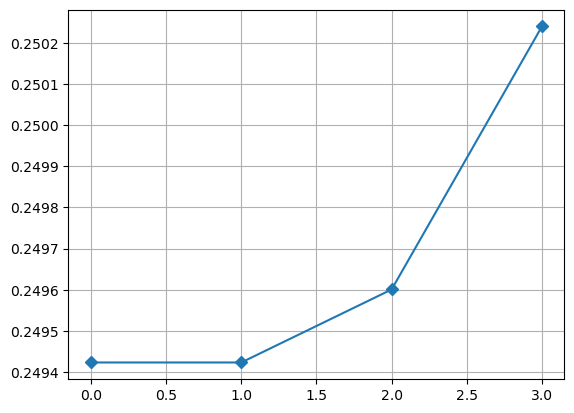

In [21]:
plot(lcoe_tab_pwl, "-D")
grid(true)

### Iterative approach to set relax_gain

In [22]:
"""Optimize sizing of microgrid using JuMP: iteration `relax_gain`

and extract results

# Parameters
- same as `optim_mg_jump`, except that
- `fixed_lifetimes=false` is assumed, so `gen_hours_assum` is not needed
- `relax_gain_start` replaces `relax_gain`
- `relax_gain_smoothing` in [0, 1[ sets how slow relax_gain is updated. 0=no smoothing
- `n_iter`: number of iterations (default 6)

Returns:
xalg_tab, lcoe_tab, rgain_tab, diagnostics, traj_alg, model_data

(the last ones are from the last iteration)
"""
function optim_mg_iter_relgain(optimizer;
        shed_max=0.0,
        ndays=365,
        relax_gain_start = 1.0,
        relax_gain_smoothing = 0.0,
        n_iter=6,
        z_tan = [0.20, 0.28, 0.37, 0.50, 0.68, 1.0, 1.7, 4.0],
        create_mg_base=create_mg_base,
        model_custom=nothing,
    )

    xalg_tab = zeros(0,length(xalg)) # global previously computed xalg here
    lcoe_tab = zeros(0,1)
    rgain_tab = zeros(n_iter,1)
    relax_gain = relax_gain_start # init
    local diagnostics, traj_alg, model_data
    
    for i in 1:n_iter
        println("relax_gain iteration $i: $relax_gain")
        rgain_tab[i] = relax_gain # store relax_gain
        xalg, lcoe_alg, diagnostics, traj_alg, model_data = optim_mg_jump(optimizer;
            shed_max, ndays,
            fixed_lifetimes=false,
            relax_gain,
            z_tan,
            create_mg_base,
            model_custom
        )
        # store results
        xalg_tab = [xalg_tab; xalg']
        lcoe_tab = [lcoe_tab; lcoe_alg]
        # correct next gain
        print("  hours/hours_lin: ")
        println(diagnostics.generator.hours / diagnostics.generator.hours_lin)
        relax_gain_target = relax_gain*diagnostics.generator.hours / diagnostics.generator.hours_lin
        relax_gain = relax_gain_smoothing*relax_gain + 
                     (1-relax_gain_smoothing)*relax_gain_target
    end
    return xalg_tab, lcoe_tab, rgain_tab, diagnostics, traj_alg, model_data
end

optim_mg_iter_relgain

In [23]:
println("")
xalg_tab, lcoe_tab, rgain_tab, diagnostics, traj_alg, model_data =  optim_mg_iter_relgain(optimizer;
    shed_max,
    #ndays=20,
    relax_gain_start = 1.0,
    n_iter=6,
    #z_tan=[0.20, 0.28, 0.37, 0.50, 0.68, 1.0, 1.7, 4.0],
    create_mg_base=create_mg_modified,
    #model_custom=nothing
)
lcoe_tab


relax_gain iteration 1: 1.0
Building stage problem with 365 days...
zero load shedding allowed
Usage-dependent generator lifetime model (relax_gain=1.0)
Xann constraints with z_tan=[0.2, 0.28, 0.37, 0.5, 0.68, 1.0, 1.7, 4.0]
 12.203321 seconds (1.65 M allocations: 117.648 MiB, 0.89% gc time)
  hours/hours_lin: 2.283988750754325
relax_gain iteration 2: 2.283988750754325
Building stage problem with 365 days...
zero load shedding allowed
Usage-dependent generator lifetime model (relax_gain=2.283988750754325)
Xann constraints with z_tan=[0.2, 0.28, 0.37, 0.5, 0.68, 1.0, 1.7, 4.0]
 10.406956 seconds (1.65 M allocations: 117.648 MiB, 0.46% gc time)
  hours/hours_lin: 0.9904394450203691
relax_gain iteration 3: 2.2621525507298794
Building stage problem with 365 days...
zero load shedding allowed
Usage-dependent generator lifetime model (relax_gain=2.2621525507298794)
Xann constraints with z_tan=[0.2, 0.28, 0.37, 0.5, 0.68, 1.0, 1.7, 4.0]
 11.011321 seconds (1.65 M allocations: 117.648 MiB, 0.

6×1 Matrix{Float64}:
 0.24302374019272588
 0.2521392036981835
 0.2519936911941726
 0.2520018758330073
 0.25200187583300726
 0.25200187583300726

In [24]:
xalg_tab

6×4 Matrix{Float64}:
 1215.98  4987.93  2132.0   1575.9
 1249.59  6072.31  2384.13  1605.97
 1250.18  6046.1   2378.02  1608.66
 1250.18  6046.1   2378.02  1608.66
 1250.18  6046.1   2378.02  1608.66
 1250.18  6046.1   2378.02  1608.66

Plot the convergence with relax_gain tuning:

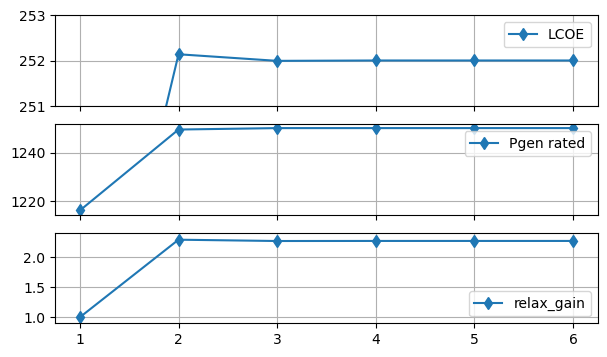

In [25]:
fig, ax = subplots(3,1, figsize=(7,4), sharex=true)

n_iter = length(rgain_tab)

ax[1].plot(1:n_iter, lcoe_tab*1000, "d-", label="LCOE")
ax[1].set_ylim(251, 253) # 365 days

ax[2].plot(1:n_iter, xalg_tab[:,1], "d-", label="Pgen rated")
#ax[2].set_ylim(630, 670)

#ax[3].plot(2:n_iter, rgain_tab[2:end]./rgain_tab[1:end-1] .- 1,
#           "d-", label="relax_gain change")
#ax[3].set_ylim(-12e-3, +12e-3)
ax[3].plot(1:n_iter, rgain_tab,
           "d-", label="relax_gain")
ax[3].set_ylim(0.9, 2.4)

for axi in ax
    axi.grid(true)
    axi.legend()
end
#ax[1].set_xlim(60, 80)
#ax[1].set_xlim(0, 10)

## Fixed lifetime approach

tests:
- 2000 vs 3000 h/y for generator
- 15 vs 10 y calendar life for storage

In [77]:
x_fxlt, lcoe_fxlt, diagnostics, traj_fxlt, model_data = optim_mg_jump(optimizer;
    shed_max,
    #ndays=30,
    fixed_lifetimes=true,
    #gen_hours_assum = 2000.,
    gen_hours_assum = 3000.,
    relax_gain,
    #z_tan=[0.20, 0.28, 0.37, 0.50, 0.68, 1.0, 1.7, 4.0],
    #create_mg_base = modify_mg_lifetimes(cal=10) ∘ create_mg_modified,
    create_mg_base = create_mg_modified,
)
@printf("LCOE: %.9f €/MWh (wrong)", lcoe_fxlt*1000)

mg lifetime modification: cal=10 y, cyc unchanged
Building stage problem with 365 days...
zero load shedding allowed
Fixed generator lifetime hypothesis: 7.5 y, assuming 2000.0  h/y of usage
  4.364898 seconds (1.64 M allocations: 115.996 MiB, 1.91% gc time)
LCOE: 248.752130296 €/MWh

Sizing with fixed lifetime vs base sizing

In [78]:
round.([x_fxlt xalg]; digits=1) # optimal sizing

4×2 Matrix{Float64}:
 1186.4  1255.5
 3495.2  5837.3
 2198.2  2329.5
 1484.5  1596.1

###### Diagnostics: battery is underpriced by 30% (0.0963/0.1399=0.69):
- CRF being used: 0.0963, i.e. CRF(15 y)
- but cycle lifetime is 9.06 y → CRF should be 0.1399

In [79]:
pprint(diagnostics.generator, "Generator diagnostics")
println()
pprint(diagnostics.storage, "Storage diagnostics")

Generator diagnostics:
- cost_share: 0.44128149872185646
- cost_share_fuel: 0.36717969527686845
- energy: 1.2891759107806042e6
- load_share: 0.19028485708673107
- hours: 2495.0
- hours_lin: 2173.301254696729
- lifetime: 6.012024048096192
- lifetime_hlin: 6.901942364218236
- CRF: 0.19667830314269383
- CRF_hlin: 0.17487993325252757
- CRF_hlin_pwl: 0.16316086288079687

Storage diagnostics:
- cost_share: 0.11474586817761262
- energy_through: 1.2422988748374572e6
- load_share: 0.09168285797177063
- cycles: 177.71262006608205
- lifetime_cycles: 8.440593579916992
- lifetime: 8.440593579916992
- CRF: 0.14812395040600537
- CRF_pwl: 0.12950457496545661


### TODO: iterative lifetime adjustment

(not biggest priority though)

## Usage penalty approach

Model customization to penalize usage variables (instead of having the nonlinear influence of usage through annualized size)

In [53]:
"""penalize generator and usage in Cann
"""
function model_penalize_usage(md, mg)
    println("Penalized usage variant")
    model = md["model"]

    # Add usage variables (not added when fixed_lifetimes=true)
    # Generator usage:
    @assert "Ugen" ∉ keys(md) "Ugen shouldn't have been defined. Make sure fixed_lifetimes=true"
    md["Ugen"] = @variable(model, Ugen >= 0) # cumulated usage
    @constraint(model, Ugen == md["Egen"]*relax_gain/mg.generator.lifetime_hours); # kW/y
    # Storage usage
    @assert "Usto" ∉ keys(md) "Usto shouldn't have been defined. Make sure fixed_lifetimes=true"
    md["Usto"] = @variable(model, Usto >= 0) # cumulated usage
    @constraint(model, Usto == md["E_through_sto"]/(2*mg.storage.lifetime_cycles))
    
    # overwrite cost function with penalties
    md["Ugen_penal"] = Ugen_penal = mg.generator.investment_price * Ugen
    md["Usto_penal"] = Usto_penal = mg.storage.investment_price * Usto
    
    md["Cann_penal"] = Cann_penal = md["Cann"] + Ugen_penal + Usto_penal
    @objective(model, Min, Cann_penal)
end

model_penalize_usage

In [54]:
mg_base.generator.fuel_price

1.0

In [55]:
fuel_price_scenar = [0.5, 1.0, 1.5] # (decrease, constant, increase)
ns = length(fuel_price_scenar)
proba_scenar = [1., 1., 1.]/ns
println("number of scenarios: $ns")

number of scenarios: 3


In [90]:
#fuel_price_scenar = [fuel_price,] # (constant, for sanity check)
#ns = length(fuel_price_scenar)
#proba_scenar = [1.,]/ns
#println("number of scenarios: $ns")

In [91]:
"""Combine annualized cost of two project fragments:
- Cann1 during T1 years
- Cann2 during T2 years, starting after T1
"""
function Cann_total(Cann1, Cann2, T1, T2, discount_rate)
    CRFproj(T) = CRF(discount_rate, T)
    NPC1 = Cann1/CRFproj(T1)
    discount2 = 1/(1+discount_rate)^T1
    NPC2 = Cann2/CRFproj(T2) * discount2

    NPC = NPC1 + NPC2
    Cann = NPC*CRFproj(lifetime)
end

# test
m = Model()
@variable(m, Cann1)
@variable(m, Cann2)
println(Cann_total(Cann1, Cann2, 10, 15, 0.0001)) # 40% , 60%
println(Cann_total(Cann1, Cann2, 10, 15, 0.10))   # 68% , 32%

0.4003000099610032 Cann1 + 0.5996999900389431 Cann2
0.676935112477701 Cann1 + 0.3230648875222989 Cann2


In [92]:
"""Setup microgrid sizing optimization model using JuMP

# Parameters:
- `shed_max`: load shedding penalty threshold should be in  [0,1[
- `optimizer`: JuMP compatible optimization solver

# Optional keyword parameters
- `ndays=365`: data reduction
- `fixed_lifetimes`: true or false (default)
- `relax_gain`: 1.0 by default. Increase to try to compensation the underestimation
  of e.g. generator operating hours due to linearization.
- and some price params (keyword params)

Sizing maximum bounds are taken as the global variables
    power_rated_gen_max,
    energy_rated_sto_max,
    power_rated_pv_max,
    power_rated_wind_max

Returns:
- mg: base microgrid
- model_data Dict, with variables, named constraints and the JuMP model
- LCOE expression
"""
function setup_optim_mg_jump_2SP(shed_max, optimizer, Tmid;
        ndays=365,
        fixed_lifetimes=false,
        relax_gain = 1.0,
        investment_price_sto=investment_price_sto,
        investment_price_gen=investment_price_gen,
        fuel_price1=fuel_price,
        fuel_price_scenar=fuel_price_scenar,
        proba_scenar=proba_scenar
    )
    ns = length(proba_scenar)
    println("number of 2nd stage scenarios: $ns")

    # base Microgrid with 1kW(h) ratings
    T1 = Tmid
    # TODO: decide where to change prices: in create_microgrid or in build model!!!
    mg1 = create_microgrid([1., 1., 1., 1.];
        investment_price_sto=investment_price_sto,
        investment_price_gen=investment_price_gen,
        fuel_price=fuel_price,
        lifetime=T1
    )
    T2 = lifetime-Tmid
    
    mg2 = [create_microgrid([1., 1., 1., 1.];
        investment_price_sto=investment_price_sto,
        investment_price_gen=investment_price_gen,
        fuel_price=fuel_price_scenar[s],
        lifetime=lifetime-Tmid
    ) for s=1:ns]

    # JuMP model setup
    model = Model(HiGHS.Optimizer)
    set_silent(model)
    
    md1 = Dict{String,Any}()
    md1["model"] = model
    build_optim_mg_stage!(mg1, shed_max, md1;
        ndays, fixed_lifetimes, relax_gain,
        investment_price_sto, investment_price_gen,
        fuel_price=fuel_price1
    )
    
    md2 = [Dict{String,Any}() for s=1:ns]
    for s=1:ns
        md2[s]["model"] = model
        build_optim_mg_stage!(mg2[s], shed_max, md2[s];
            ndays, fixed_lifetimes, relax_gain,
            investment_price_sto, investment_price_gen,
            fuel_price=fuel_price_scenar[s]
        )
    end    

    discount_rate = mg1.project.discount_rate
    Cann_scenar = [
        Cann_total(md1["Cann"], md2[s]["Cann"], T1, T2, discount_rate)
        for s=1:ns]
    # Expected annualized cost
    Cann = Cann_scenar' * proba_scenar
    
    dt = mg1.project.timestep
    Eload_desired = sum(mg1.load)*dt*365/ndays
    LCOE = Cann/Eload_desired

    @objective(model, Min, Cann)

    return mg1, md1, md2, LCOE
end

setup_optim_mg_jump_2SP

In [93]:
"""Optimize sizing of microgrid optimization using JuMP

Parameters: see `setup_optim_mg_jump`. Extra optional parameter:
- `model_custom`: a function taking `model_data` as arg and which can modify the optimization model
"""
function optim_mg_jump_2SP(shed_max, optimizer, Tmid;
        model_custom=nothing,
        ndays=365,
        fixed_lifetimes=false,
        relax_gain=1.0,
        investment_price_sto=investment_price_sto,
        investment_price_gen=investment_price_gen,
        fuel_price1=fuel_price,
        fuel_price_scenar=fuel_price_scenar,
        proba_scenar=proba_scenar
    )
    # Create model
    mg1_base, md1, md2, LCOE = setup_optim_mg_jump_2SP(shed_max, optimizer, Tmid;
        ndays=ndays,
        fixed_lifetimes=fixed_lifetimes,
        relax_gain=relax_gain,
        investment_price_sto=investment_price_sto,
        investment_price_gen=investment_price_gen,
        fuel_price1=fuel_price1,
    )
    model = md1["model"]
    
    if model_custom !== nothing
        model_custom(md1)
        model_custom.(md2)
    end

    # Stage coupling constraints:
    @constraint(model, [s=1:ns], md2[s]["power_rated_pv"] >= md1["power_rated_pv"]) # PV cannot decrease
    @constraint(model, [s=1:ns], md2[s]["power_rated_wind"] >= md1["power_rated_wind"]) # wind cannot decrease

    # Display model stats before solving
    show(model)
    # Optimize
    println("optmization started")
    @time JuMP.optimize!(model)

    # Extract results
    LCOE_opt = value(LCOE)
    x_varnames = ["power_rated_gen", "energy_rated_sto", "power_rated_pv", "power_rated_wind"]
    xopt1 = value.([
        md1["power_rated_gen"]
        md1["energy_rated_sto"]
        md1["power_rated_pv"]
        md1["power_rated_wind"]
    ])
    xopt2 = value.([
        md2[s][name] for name in x_varnames, s=1:ns
    ])
    return LCOE_opt, xopt1, xopt2, md1, md2
end

optim_mg_jump_2SP

In [94]:
optimizer = HiGHS.Optimizer
#optimizer = Clp.Optimizer
Tmid= 10 # y
lcoe_alg_2SP, xalg_S1, xalg_S2, md1, md2 = optim_mg_jump_2SP(shed_max, optimizer, Tmid;
    ndays=365,
    relax_gain=1.0,
    investment_price_sto=investment_price_sto*0.25,
    investment_price_gen=investment_price_gen,
    fuel_price1=fuel_price,
    fuel_price_scenar=fuel_price_scenar,
    proba_scenar=proba_scenar
)
lcoe_alg_2SP

number of 2nd stage scenarios: 3
Building stage problem with 365 days...
Usage-dependant lifetime hypothesis for generator (relax_gain=1.0)
Building stage problem with 365 days...
Usage-dependant lifetime hypothesis for generator (relax_gain=1.0)
Building stage problem with 365 days...
Usage-dependant lifetime hypothesis for generator (relax_gain=1.0)
Building stage problem with 365 days...
Usage-dependant lifetime hypothesis for generator (relax_gain=1.0)
A JuMP Model
Minimization problem with:
Variables: 315396
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 175212 constraints
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 35150 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 175204 constraints
`VariableRef`-in-`MathOptInterface.EqualTo{Float64}`: 35040 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 140192 constraints
`VariableRef`-in-`MathOptInterface.LessThan{Float64}`: 16 constraints
Model mode: AUTOMA

0.17060043890892865

LCOE: `0.170 600 438 908 92865` \\$/kWh (two stage with fuel price scenario [0.5, 1.0, 1.5]\\$/l), with PV and wind *nondecrease* constraint. Solving time: 180s (×12 compared to single stage)

Sanity check: if 2nd stage scenario is constant (fuel price at 1.0 \\$/l), then we indeed get LCOE `0.171 593 718 600 32852` and two identical stage sizings, equal to the single stage base case. Solving time 45 s (×3 compared to single stage)

Optimal sizing at all stages:

In [95]:
round.([xalg_S1 xalg_S2]; digits=1) 

4×4 Matrix{Float64}:
 1190.0  1228.9  1151.3  1077.8
 4187.6  2752.8  5227.9  7164.0
 1791.9  1791.9  2055.0  2556.4
 1209.1  1209.1  1234.5  1351.6

Obtained sizing: $x^*=$

```
    S1 1.0  S2 0.5  S2 1.0  S2 1.5 $/l
Gen 1190.0  1228.9  1151.3  1077.8
Sto 4187.6  2752.8  5227.9  7164.0
PV  1791.9  1791.9  2055.0  2556.4
Win 1209.1  1209.1  1234.5  1351.6
```

For comparison: single stage base case:

LCOE: `0.171 593 718 600 3287` 

Sizing $x^*$:
```
 1151.3
 5227.9
 2055.0
 1234.5
```

Observations:
- Stage 1 of 2SP is
  - *matching S2 low price scenar* for the PV and wind ratings
  - uses slightly bigger gen (1190 vs 1151 kW)  and slightly smaller "anything else" (Sto, PV, wind) than the single stage base case
- Stage 2 mid price scenar *matches exactly* the single stage base case
- Stage 2 low price scenar downsizes the battery (4.2 to 2.8 MWh). Gen is slightly bigger
- Stage 2 high price scenar oversize the battery (4.2 to 7.2 MWh). PV and wind also, but just slighlty. Gen is slightly smaller.
- Wind ratings increases for S2 mid and high price scenar are so small that there are not realistic. A practical application would require rerunning the optim by requiring a constant wind sizing (or adding a nonconvex fixed price penalty to discourage small wind additions). 

*→ it seems to work!*

In [88]:
x_penal, lcoe_penal, diagnostics, traj_penal, model_data = optim_mg_jump(optimizer;
    shed_max,
    #ndays=30,
    fixed_lifetimes=true,
    #gen_hours_assum = 3000.,
    relax_gain,
    create_mg_base = create_mg_modified,
    model_custom = model_penalize_usage
)
@printf("LCOE: %.9f €/MWh (wrong)", lcoe_penal*1000)

Building stage problem with 365 days...
zero load shedding allowed
Fixed generator lifetime hypothesis: 5.0 y, assuming 3000.0  h/y of usage
Penalized usage variant
  6.007945 seconds (1.64 M allocations: 117.502 MiB, 6.28% gc time)
LCOE: 256.087752129 €/MWh (wrong)

Amount of penalties: +10% (not counted in LCOE!)

In [89]:
value(model_data["Cann_penal"])/value(model_data["Cann"])

1.0967920295542388

Sizing with usage penaly vs fixed lt vs base sizing
- even smaller battery

In [90]:
round.([x_penal x_fxlt xalg]; digits=1) # optimal sizing

4×3 Matrix{Float64}:
 1261.5  1186.4  1255.5
 2106.0  3495.2  5837.3
 1729.7  2198.2  2329.5
 1648.8  1484.5  1596.1

In [83]:
pprint(diagnostics.generator, "Generator diagnostics")
println()
pprint(diagnostics.storage, "Storage diagnostics")

Generator diagnostics:
- cost_share: 0.511087327435998
- cost_share_fuel: 0.40028634239898825
- energy: 1.44685928768005e6
- load_share: 0.21355922840204375
- hours: 2848.0
- hours_lin: 2293.8876767509573
- lifetime: 5.26685393258427
- lifetime_hlin: 6.539117042228446
- CRF: 0.2206442710024572
- CRF_hlin: 0.18304500651599442
- CRF_hlin_pwl: 0.23097479812826793

Storage diagnostics:
- cost_share: 0.05306956234796433
- energy_through: 778005.3575405942
- load_share: 0.05741754753340152
- cycles: 184.7091873603728
- lifetime_cycles: 8.120873798624093
- lifetime: 8.120873798624093
- CRF: 0.1528395203955612
- CRF_pwl: 0.09634228760924432


### Case when storage cyle life is not active

by setting calendar lifetime to 10 year (while the optimum is 10.x years)


#### Our method:

makes the best use of those 10 years, with T_cycle = 9.99 years !

In [84]:
create_mg_modified_cal10y = modify_mg_lifetimes(cal=10) ∘ create_mg_modified

x_alg10y, lcoe_alg10y, diagnostics, traj_alg10y, model_data = optim_mg_jump(optimizer;
    shed_max,
    #ndays=10,
    relax_gain,
    create_mg_base = create_mg_modified_cal10y,
)
@printf("LCOE: %.9f €/MWh", lcoe_alg10y*1000)

mg lifetime modification: cal=10 y, cyc unchanged
Building stage problem with 365 days...
zero load shedding allowed
Usage-dependent generator lifetime model (relax_gain=2.0)
Xann constraints with z_tan=[0.2, 0.28, 0.37, 0.5, 0.68, 1.0, 1.7, 4.0]
 13.683733 seconds (1.65 M allocations: 117.648 MiB, 0.21% gc time)
LCOE: 250.492323824 €/MWh

Sizing vs base sizing

In [86]:
round.([x_alg10y xalg]; digits=1) # optimal sizing

4×2 Matrix{Float64}:
 1184.4  1255.5
 5131.2  5837.3
 2296.4  2329.5
 1584.0  1596.1

Observation: T_cycle = 9.99 years !

In [87]:
pprint(diagnostics.storage, "Storage diagnostics")

Storage diagnostics:
- cost_share: 0.16728362196577656
- energy_through: 1.5406589676988088e6
- load_share: 0.11370212126847985
- cycles: 150.1255855113518
- lifetime_cycles: 9.991634636366344
- lifetime: 9.991634636366344
- CRF: 0.12958869413255772
- CRF_pwl: 0.12950457496545661
